### SLAM Outline Step by Step:

- feature extraction
- feature matching
- camera pose estimation
- triangulation for 3D mapping

## Imports

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

## feature extraction

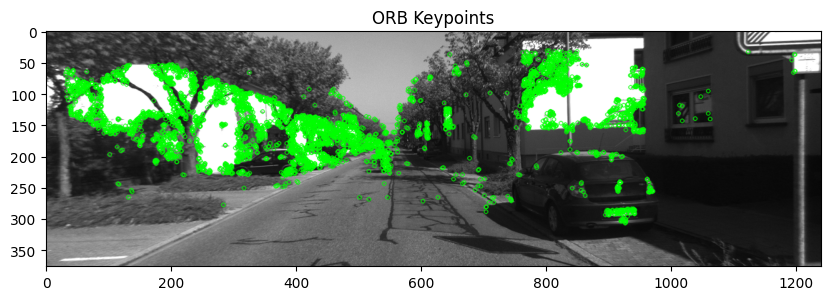

In [5]:


# Load the image
image = cv2.imread('../data/data_odometry_gray/dataset/sequences/00/image_0/000000.png', cv2.IMREAD_GRAYSCALE)

# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw the keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)

# Display the image with keypoints
plt.figure(figsize=(10, 10))
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('ORB Keypoints')
plt.show()


## feature matching

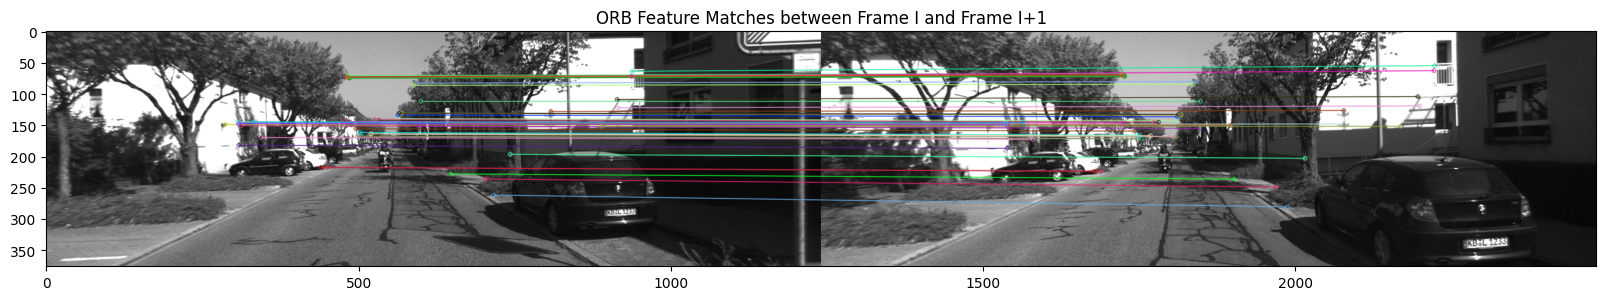

Matched points in frame I:
[[559.      165.     ]
 [562.5596  139.7441 ]
 [806.4     148.8    ]
 ...
 [922.80005 138.     ]
 [529.92004 187.20001]
 [533.      221.     ]]
Matched points in frame I+1:
[[567.      169.     ]
 [569.7259  143.32727]
 [836.64    148.32   ]
 ...
 [799.2      68.4    ]
 [537.60004 189.6    ]
 [651.45605 311.04004]]


In [8]:
# Load the initial image (frame I)
image1 = cv2.imread('../data/data_odometry_gray/dataset/sequences/00/image_0/000000.png', cv2.IMREAD_GRAYSCALE)

# Load the subsequent image (frame I+1)
image2 = cv2.imread('../data/data_odometry_gray/dataset/sequences/00/image_0/000003.png', cv2.IMREAD_GRAYSCALE)

# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures=10000)

# Detect keypoints and compute descriptors for the first image
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)

# Detect keypoints and compute descriptors for the second image
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Initialize the BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches (for example, the top 50 matches)
top_matches = matches[:50]
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image with matches
plt.figure(figsize=(20, 15))
plt.imshow(matched_image)
plt.title('ORB Feature Matches between Frame I and Frame I+1')
plt.show()

# Optionally, extract the matched points
matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Print the coordinates of the matched points
print("Matched points in frame I:")
print(matched_points1)
print("Matched points in frame I+1:")
print(matched_points2)


## pose estimation:

In [3]:
# pose estimation
K = np.array([[3177.000, 0, 1632.000],
            [0, 3177.00, 1224.00],
            [0, 0, 1]])


# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Compute the Fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1_inliers = pts1[inliers.ravel() == 1]
pts2_inliers = pts2[inliers.ravel() == 1]

# estimate essential matrix
E = K.T @ F @ K

_, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print("Rotation matrix R:")
print(R)
print("Translation vector t:")
print(t)

Rotation matrix R:
[[ 9.99395960e-01  7.79244748e-04  3.47434716e-02]
 [ 2.14572778e-03  9.96457463e-01 -8.40709283e-02]
 [-3.46859034e-02  8.40946961e-02  9.95853890e-01]]
Translation vector t:
[[-0.00534773]
 [-0.26372555]
 [-0.96458293]]


## Triangulation for 3D Mapping:

In [4]:
def add_ones(x):
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)

T = np.eye(4) 
T[0:3,0:3] = R
T[0:3,3] = t.T
Kinv = np.linalg.inv(K)
pose1 = np.eye(4)
pose2 = np.eye(4) @ T

# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])



ret = np.zeros((pts1.shape[0], 4))
pose1 = np.linalg.inv(pose1)
pose2 = np.linalg.inv(pose2)
for i, p in enumerate(zip(add_ones(pts1), 
                          add_ones(pts2))):
    A = np.zeros((4, 4))
    A[0] = p[0][0] * pose1[2] - pose1[0]
    A[1] = p[0][1] * pose1[2] - pose1[1]
    A[2] = p[1][0] * pose2[2] - pose2[0]
    A[3] = p[1][1] * pose2[2] - pose2[1]
    _, _, vt = np.linalg.svd(A)
    ret[i] = vt[3]

ret /= ret[:, 3:]
good_pts4d =   (np.abs(ret[:, 3]) > 0.005) & (ret[:, 2] > 0)

mapp_pts = [p for i, p in enumerate(ret) if good_pts4d[i]]




(3021, 2) (3021, 2)


[array([2.37186913e+01, 2.09503806e+01, 1.41443596e-02, 1.00000000e+00]),
 array([5.12968306e+00, 1.32466891e+01, 8.17139020e-03, 1.00000000e+00]),
 array([ 2.54072544, 11.97755524,  0.01206808,  1.        ]),
 array([5.15455206e+00, 1.32568761e+01, 8.18360935e-03, 1.00000000e+00]),
 array([3.08114816e+01, 2.38776602e+01, 1.81653315e-02, 1.00000000e+00]),
 array([8.39007676e+01, 4.58448029e+01, 3.25148166e-02, 1.00000000e+00]),
 array([2.19522990e+01, 2.02213518e+01, 1.31653936e-02, 1.00000000e+00]),
 array([3.06866991e+01, 2.38277553e+01, 1.77449561e-02, 1.00000000e+00]),
 array([2.91361555e+00, 1.22216615e+01, 1.09275785e-02, 1.00000000e+00]),
 array([1.94119575e+00, 1.19152192e+01, 7.92148090e-03, 1.00000000e+00]),
 array([3.25918880e+00, 1.24037972e+01, 1.02260319e-02, 1.00000000e+00]),
 array([3.29424022e+01, 2.46497825e+01, 2.89789520e-02, 1.00000000e+00]),
 array([6.79951063e+00, 1.39458569e+01, 8.33258756e-03, 1.00000000e+00]),
 array([7.99570735e+01, 4.42231932e+01, 2.76580969

## Save Map in a File 

In [8]:
import open3d as o3d
import numpy as np

# Assume mapp_pts is a list of 3D points obtained from the previous code
mapp_pts = np.array(mapp_pts)  # Convert to a NumPy array if it's not already

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Convert the NumPy array to Open3D format
pcd.points = o3d.utility.Vector3dVector(mapp_pts[:, :3])

# Create an array of white colors
colors = np.zeros((mapp_pts.shape[0], 3))
colors[:, 1] = 1  # Set the green channel to 1

# Assign the colors to the point cloud
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save the point cloud to a .pcd file
o3d.io.write_point_cloud("points_colored_structurev2.ply", pcd)

True